## We now have clean, good ride requests data.
### Cluster of Latitude-Longitude is done, we have around 50 pickup_clusters.
### We have grouped ride request day in 30mins interval. 

### Total Data Rows: 366days * 48 intervals * 50 clusters = 878400

### `AIM: To forecast demand for a given latitude-longitude`

### `Metric: RMSE, how close we are able to predict ride demand to true value`


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from math import sqrt, ceil, floor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from joblib import dump, load
%matplotlib inline

In [2]:
df = pd.read_csv('Data_Prepared.csv', compression = 'gzip')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878400 entries, 0 to 878399
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ts              878400 non-null  object 
 1   pickup_cluster  878400 non-null  int64  
 2   request_count   878400 non-null  float64
 3   mins            878400 non-null  int64  
 4   hour            878400 non-null  int64  
 5   day             878400 non-null  int64  
 6   month           878400 non-null  int64  
 7   dayofweek       878400 non-null  int64  
 8   quarter         878400 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 60.3+ MB


In [4]:
df['request_count'] = pd.to_numeric(df['request_count'], downcast = 'integer')
df.ts = pd.to_datetime(df.ts)
df.head(10)

,ts,pickup_cluster,request_count,mins,hour,day,month,dayofweek,quarter
0,2020-03-26 00:00:00,0,0,0,0,26,3,3,1
1,2020-03-26 00:30:00,0,0,30,0,26,3,3,1
2,2020-03-26 01:00:00,0,0,0,1,26,3,3,1
3,2020-03-26 01:30:00,0,0,30,1,26,3,3,1
4,2020-03-26 02:00:00,0,0,0,2,26,3,3,1
5,2020-03-26 02:30:00,0,0,30,2,26,3,3,1
6,2020-03-26 03:00:00,0,0,0,3,26,3,3,1
7,2020-03-26 03:30:00,0,0,30,3,26,3,3,1
8,2020-03-26 04:00:00,0,0,0,4,26,3,3,1
9,2020-03-26 04:30:00,0,0,30,4,26,3,3,1


In [5]:
df = df[['ts','pickup_cluster','mins','hour','month','quarter','dayofweek','request_count']]

In [6]:
df

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count
0,2020-03-26 00:00:00,0,0,0,3,1,3,0
1,2020-03-26 00:30:00,0,30,0,3,1,3,0
2,2020-03-26 01:00:00,0,0,1,3,1,3,0
3,2020-03-26 01:30:00,0,30,1,3,1,3,0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0
...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,11
878396,2021-03-26 22:00:00,49,0,22,3,1,4,7
878397,2021-03-26 22:30:00,49,30,22,3,1,4,5
878398,2021-03-26 23:00:00,49,0,23,3,1,4,5


In [7]:
# First 24days of every month in Train and last 7 days of everymonth in Test
df_train = df[df.ts.dt.day <=23]
df_test = df[df.ts.dt.day >23]

In [8]:
len(df_train)

662400

In [9]:
len(df_test)

216000

In [10]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

In [11]:
def metrics_calculate(regressor):
    y_pred = regressor.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, y_pred))
    return rms

# Iteration: 1
Features: ['pickup_cluster','mins','hour','month','quarter','dayofweek']

In [12]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 6.323033485725794, RMSE TEST:6.2640712553058115


### High Bais | Underfit
#### It is used to determine the extent to which there is a linear relationship between a dependent variable and one or more independent variables.
#### Moving to Ensemble Regressors: Bagging Algorithm Random Forest 
#### Random Forest Regressor: Random forests are bagged decision tree models that split on a subset of features on each split.
#### Give Feature importance based on target variable

In [13]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state=42, n_jobs = -1, verbose=True)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   46.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.9s


RMSE TRAIN: 1.8972985741703188, RMSE TEST:4.081335757489472


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    3.2s finished


In [14]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
pickup_cluster,0.374507
hour,0.279326
month,0.139741
quarter,0.111985
dayofweek,0.076420
mins,0.018021


### Random Forest Tend to Overfit

### Moving to a Ensemble: Boosting Algorithm
+ Here: learners are learned sequentially

In [15]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1000, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=15,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

[0]	validation_0-rmse:6.45783
[1]	validation_0-rmse:6.43020
[2]	validation_0-rmse:6.40383


/Users/abhignaragala/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhignaragala/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:6.37753
[4]	validation_0-rmse:6.35211
[5]	validation_0-rmse:6.32677
[6]	validation_0-rmse:6.30225
[7]	validation_0-rmse:6.27772
[8]	validation_0-rmse:6.25410
[9]	validation_0-rmse:6.22973
[10]	validation_0-rmse:6.20613
[11]	validation_0-rmse:6.18244
[12]	validation_0-rmse:6.15970
[13]	validation_0-rmse:6.13676
[14]	validation_0-rmse:6.11568
[15]	validation_0-rmse:6.09400
[16]	validation_0-rmse:6.07376
[17]	validation_0-rmse:6.05288
[18]	validation_0-rmse:6.03315
[19]	validation_0-rmse:6.01349
[20]	validation_0-rmse:5.99326
[21]	validation_0-rmse:5.97437
[22]	validation_0-rmse:5.95530
[23]	validation_0-rmse:5.93587
[24]	validation_0-rmse:5.91798
[25]	validation_0-rmse:5.90028
[26]	validation_0-rmse:5.88187
[27]	validation_0-rmse:5.86430
[28]	validation_0-rmse:5.84776
[29]	validation_0-rmse:5.83142
[30]	validation_0-rmse:5.81323
[31]	validation_0-rmse:5.79612
[32]	validation_0-rmse:5.77959
[33]	validation_0-rmse:5.76265
[34]	validation_0-rmse:5.74656
[35]	validation

In [16]:
import os
from joblib import dump

# Specify the model directory
model_directory = 'Model'  # Adjust the directory path as needed

# Ensure the directory exists
os.makedirs(model_directory, exist_ok=True)

# Save the model
dump(model, os.path.join(model_directory, 'prediction_model_without_lag.joblib'), compress=3)


['Model/prediction_model_without_lag.joblib']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

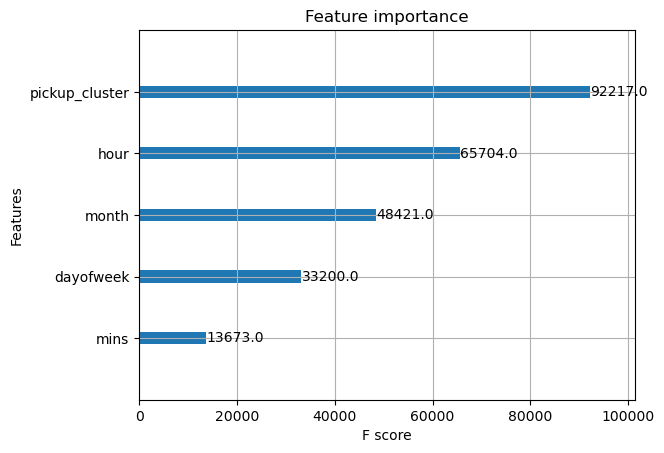

In [17]:
# plot feature importance
plot_importance(model)


# Iteration 2
Features: ['pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3']

## Include: Lag Features

### If there is 30mins trend, how has ride requests been in last 1.5 hours. 
+ Hence testing with Lag Shift by 3

lag_{t} = this is simply the request_count of a region {t} mins/hours ago.

The partial autocorrelation function shows a high correlation with the first two lag and lesser correlation with the 3rd and 4th lag. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.

+ ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
+ PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons

In [18]:
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = temp.set_index(['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp.head(15)

,,,,,,,request_count,lag_1,lag_2,lag_3
ts,pickup_cluster,mins,hour,month,quarter,dayofweek,,,,
2020-03-26 00:00:00,0,0,0,3,1,3,0,NaN,NaN,NaN
2020-03-26 00:30:00,0,30,0,3,1,3,0,0.0,NaN,NaN
2020-03-26 01:00:00,0,0,1,3,1,3,0,0.0,0.0,NaN
2020-03-26 01:30:00,0,30,1,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:00:00,0,0,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:30:00,0,30,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:00:00,0,0,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:30:00,0,30,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 04:00:00,0,0,4,3,1,3,0,0.0,0.0,0.0


In [19]:
temp = temp.reset_index(drop = False).dropna()
temp = temp[['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3',
        'request_count']]

In [20]:
train1 = temp[temp.ts.dt.day <=23]
test1 = temp[temp.ts.dt.day >23]

In [21]:
X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

In [22]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 0.962001914302714, RMSE TEST:2.5531781790580323


### Random Fores - Overfits || Moving to Boosting Algorithm

In [23]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
lag_1,0.791170
hour,0.045228
pickup_cluster,0.041994
lag_2,0.038955
lag_3,0.030521
dayofweek,0.021006
month,0.018561
mins,0.008044
quarter,0.004521


In [24]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=600, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=30,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

[0]	validation_0-rmse:6.43453
[1]	validation_0-rmse:6.38262


/Users/abhignaragala/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhignaragala/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:6.33136
[3]	validation_0-rmse:6.28055
[4]	validation_0-rmse:6.23036
[5]	validation_0-rmse:6.18073
[6]	validation_0-rmse:6.13177
[7]	validation_0-rmse:6.08342
[8]	validation_0-rmse:6.03548
[9]	validation_0-rmse:5.98818
[10]	validation_0-rmse:5.94149
[11]	validation_0-rmse:5.89521
[12]	validation_0-rmse:5.84957
[13]	validation_0-rmse:5.80458
[14]	validation_0-rmse:5.76002
[15]	validation_0-rmse:5.71589
[16]	validation_0-rmse:5.67241
[17]	validation_0-rmse:5.62935
[18]	validation_0-rmse:5.58689
[19]	validation_0-rmse:5.54490
[20]	validation_0-rmse:5.50342
[21]	validation_0-rmse:5.46251
[22]	validation_0-rmse:5.42201
[23]	validation_0-rmse:5.38198
[24]	validation_0-rmse:5.34246
[25]	validation_0-rmse:5.30352
[26]	validation_0-rmse:5.26505
[27]	validation_0-rmse:5.22716
[28]	validation_0-rmse:5.18958
[29]	validation_0-rmse:5.15233
[30]	validation_0-rmse:5.11567
[31]	validation_0-rmse:5.07951
[32]	validation_0-rmse:5.04363
[33]	validation_0-rmse:5.00830
[34]	validation_

In [35]:
# Assuming you have a new DataFrame 'new_data' with the same features as your training data
# Make sure to preprocess the 'new_data' DataFrame in the same way you did for training data

# Placeholder for 'new_data' (replace this with your actual new data)
new_data = pd.DataFrame({
    'pickup_cluster': [10],
    'mins': [30],
    'hour': [1],
    'month': [11],
    'quarter': [3],
    'dayofweek': [1],
    'lag_1': [5],
    'lag_2': [4],
    'lag_3': [7]
})

# Load the saved XGBoost model
loaded_model = load('Model/prediction_model_without_lag.joblib')

# Predict ride demand for new data
new_data_predictions = loaded_model.predict(new_data[['pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3']])

# Print or use the predictions as needed
print(new_data_predictions)


[2.069799]
